# Train & Eval

In [10]:
from google.colab import drive
import pandas as pd
import os
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from yellowbrick.classifier import ROCAUC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive')

# Load the ready-to-use sets
X_train = pd.read_parquet('/content/drive/My Drive/Flights/X_train.parquet')
X_test = pd.read_parquet('/content/drive/My Drive/Flights/X_test.parquet')
y_train = pd.read_parquet('/content/drive/My Drive/Flights/y_train.parquet')['is_delayed']
y_test = pd.read_parquet('/content/drive/My Drive/Flights/y_test.parquet')['is_delayed']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# 1. Initialize Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'Random Forest': RandomForestClassifier(n_estimators=100),
}

# 2. Setup Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

print("Starting Cross-Validation...")

# 3. Iterate and Evaluate
for name, model in models.items():
    # Use 'roc_auc' as the primary metric
    auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

    results.append({
        'Model': name,
        'Mean AUC': auc_scores.mean(),
        'Std Dev': auc_scores.std()
    })

    print(f"{name}: Mean AUC = {auc_scores.mean():.4f} (+/- {auc_scores.std():.4f})")

# 4. Store and Display Results
results_df = pd.DataFrame(results).sort_values(by='Mean AUC', ascending=False)

Starting Cross-Validation...
Logistic Regression: Mean AUC = 0.6561 (+/- 0.0011)
XGBoost: Mean AUC = 0.6624 (+/- 0.0010)


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest: Mean AUC = 0.6258 (+/- 0.0011)
Naive Bayes: Mean AUC = 0.6302 (+/- 0.0015)


## WINNER XGBOOST

# Eval

In [24]:
xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=4,
    eval_metric='auc',
    random_state=42
)

xgb.fit(X_train, y_train)

xgb.score(X_train, y_train)

metrics.precision_score(
    y_test,
    xgb.predict(X_test)
)

0.24650310081028473

In [25]:
for col, val in sorted(
    zip(
        X_train.columns,
        xgb.feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

is_summer_travel     0.124
airport_route     0.099
tail_number     0.085
month_cos      0.061
is_near_holiday     0.046


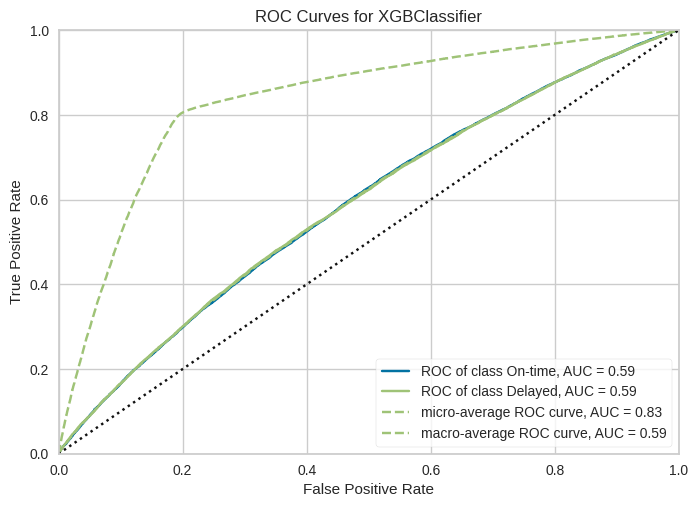

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [26]:
model_to_viz = XGBClassifier()
visualizer = ROCAUC(model_to_viz, classes=["On-time", "Delayed"])

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

--- Classification Report ---
              precision    recall  f1-score   support

 On-time (0)       0.84      0.63      0.72     90078
 Delayed (1)       0.25      0.50      0.33     21766

    accuracy                           0.60    111844
   macro avg       0.54      0.57      0.52    111844
weighted avg       0.72      0.60      0.64    111844

Overall Accuracy: 0.6038


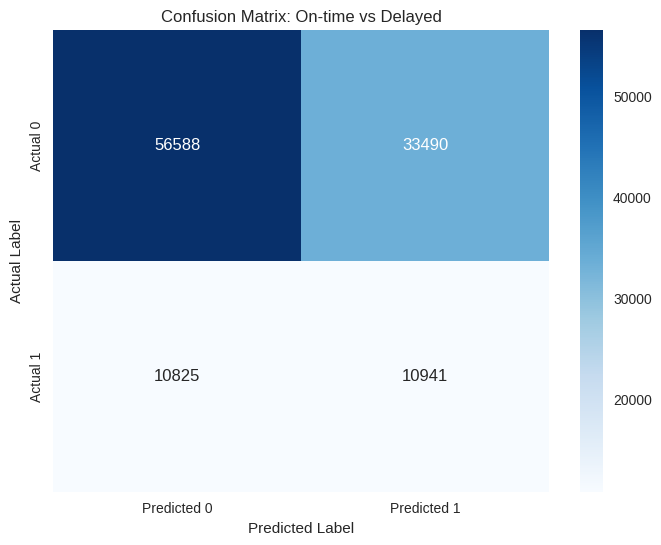

In [27]:
y_pred = xgb_model.predict(X_test)

print("--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['On-time (0)', 'Delayed (1)']))

print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix: On-time vs Delayed')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# 1. Initialize with GPU and Early Stopping support
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42,
    tree_method='hist',
    early_stopping_rounds=20
)

# 2. Refined Parameter Grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'scale_pos_weight': [3, 4, 5]
}

# 3. Setup Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=15,
    scoring='roc_auc',
    cv=3,
    n_jobs=1,
    verbose=2,
    random_state=42
)

# 4. Fit using a validation set for Early Stopping
random_search.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best AUC Score: {random_search.best_score_:.4f}")

best_xgb = random_search.best_estimator_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:21:04] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, scale_pos_weight=5, subsample=0.7; total time=   3.7s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:21:08] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, scale_pos_weight=5, subsample=0.7; total time=   6.1s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:21:14] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, scale_pos_weight=5, subsample=0.7; total time=   3.5s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:21:17] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, scale_pos_weight=3, subsample=0.7; total time=   2.7s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:21:20] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, scale_pos_weight=3, subsample=0.7; total time=   2.9s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:21:23] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, scale_pos_weight=3, subsample=0.7; total time=   4.9s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:21:28] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, scale_pos_weight=3, subsample=0.9; total time=   4.0s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:21:32] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, scale_pos_weight=3, subsample=0.9; total time=   4.0s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:21:36] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, scale_pos_weight=3, subsample=0.9; total time=   6.7s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:21:43] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, scale_pos_weight=3, subsample=0.7; total time=   3.9s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:21:46] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, scale_pos_weight=3, subsample=0.7; total time=   3.1s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:21:49] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, scale_pos_weight=3, subsample=0.7; total time=   4.3s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:21:54] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, scale_pos_weight=3, subsample=0.7; total time=   7.2s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:22:01] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, scale_pos_weight=3, subsample=0.7; total time=   7.3s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:22:09] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, scale_pos_weight=3, subsample=0.7; total time=   7.2s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:22:15] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, scale_pos_weight=3, subsample=0.7; total time=   3.4s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:22:19] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, scale_pos_weight=3, subsample=0.7; total time=   6.1s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:22:25] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, scale_pos_weight=3, subsample=0.7; total time=   3.5s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:22:28] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, scale_pos_weight=4, subsample=0.7; total time=   6.3s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:22:35] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, scale_pos_weight=4, subsample=0.7; total time=  10.3s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:22:45] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, scale_pos_weight=4, subsample=0.7; total time=   9.5s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:22:55] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, scale_pos_weight=5, subsample=0.8; total time=  18.0s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:23:13] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, scale_pos_weight=5, subsample=0.8; total time=  16.3s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:23:29] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, scale_pos_weight=5, subsample=0.8; total time=   9.6s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:23:39] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, scale_pos_weight=4, subsample=0.9; total time=   6.9s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:23:46] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, scale_pos_weight=4, subsample=0.9; total time=   9.6s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:23:55] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, scale_pos_weight=4, subsample=0.9; total time=   7.2s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:24:03] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, scale_pos_weight=3, subsample=0.7; total time=   8.3s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:24:11] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, scale_pos_weight=3, subsample=0.7; total time=   6.6s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:24:18] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, scale_pos_weight=3, subsample=0.7; total time=   8.1s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:24:25] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, scale_pos_weight=5, subsample=0.9; total time=   3.9s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:24:29] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, scale_pos_weight=5, subsample=0.9; total time=   6.5s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:24:36] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, scale_pos_weight=5, subsample=0.9; total time=   3.9s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:24:40] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, scale_pos_weight=3, subsample=0.9; total time=   3.4s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:24:43] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, scale_pos_weight=3, subsample=0.9; total time=   5.2s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:24:49] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, scale_pos_weight=3, subsample=0.9; total time=   3.9s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:24:52] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, scale_pos_weight=3, subsample=0.8; total time=   3.1s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:24:55] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, scale_pos_weight=3, subsample=0.8; total time=  10.1s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:25:06] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, scale_pos_weight=3, subsample=0.8; total time=   3.6s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:25:09] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, scale_pos_weight=5, subsample=0.8; total time=   3.0s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:25:12] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, scale_pos_weight=5, subsample=0.8; total time=   5.3s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:25:18] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, scale_pos_weight=5, subsample=0.8; total time=   3.3s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:25:21] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, scale_pos_weight=5, subsample=0.7; total time=   6.1s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:25:27] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, scale_pos_weight=5, subsample=0.7; total time=   8.7s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:25:36] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, scale_pos_weight=5, subsample=0.7; total time=   6.1s


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [00:25:42] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best AUC Score: 0.6650


In [32]:
xgb_tuned = XGBClassifier(
    subsample=0.8,
    scale_pos_weight=5,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.8,
    eval_metric='auc',
    early_stopping_rounds=20
)

xgb_tuned.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.55962
[1]	validation_0-auc:0.56855
[2]	validation_0-auc:0.57047
[3]	validation_0-auc:0.57173
[4]	validation_0-auc:0.57313
[5]	validation_0-auc:0.57328
[6]	validation_0-auc:0.57427
[7]	validation_0-auc:0.57688
[8]	validation_0-auc:0.57632
[9]	validation_0-auc:0.57697
[10]	validation_0-auc:0.57693
[11]	validation_0-auc:0.57670
[12]	validation_0-auc:0.57866
[13]	validation_0-auc:0.57863
[14]	validation_0-auc:0.57863
[15]	validation_0-auc:0.57874
[16]	validation_0-auc:0.57867
[17]	validation_0-auc:0.57926
[18]	validation_0-auc:0.58002
[19]	validation_0-auc:0.57976
[20]	validation_0-auc:0.57976
[21]	validation_0-auc:0.57966
[22]	validation_0-auc:0.57982
[23]	validation_0-auc:0.57970
[24]	validation_0-auc:0.57963
[25]	validation_0-auc:0.57945
[26]	validation_0-auc:0.57986
[27]	validation_0-auc:0.57969
[28]	validation_0-auc:0.57971
[29]	validation_0-auc:0.57971
[30]	validation_0-auc:0.58016
[31]	validation_0-auc:0.58060
[32]	validation_0-auc:0.58055
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)